In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import fsolve
import pickle

%matplotlib notebook
import matplotlib.pyplot as plt

To understand the effects of noise (or limiting mag) on one's ability to recover the time of explosion (or better, the time of first light for a young SN), we construct a simple generative model to simulate the flux from the SN. 

In [Zheng & Filippenko (2017)](http://adsabs.harvard.edu/abs/2017ApJ...838L...4Z), a broken power-law parameterization of SN Ia light curves is introduced. This parameterization is somewhat physically motivated, however, there are some assumptions that break down for some SNe Ia. A major advantage of this method, however, is that it covers the peak and turn-over of SN light curves, so there is no need to artificially truncate the data (to ~5 d after explosion for example) in order to only fit the early rise. 

The formulation is: 

$$L = A' \left(\frac{t - t_0}{t_b}\right)^{\alpha_\mathrm{r}} \left[1 + \left(\frac{t - t_0}{t_b}\right)^{s\alpha_\mathrm{d}}\right]^{-2/s}$$

which has a peak value when:

$$ t_p = t_b \times \left(-\frac{\alpha_1 + 1}{\alpha_2 + 1}\right)^{1/[s(\alpha_1 - \alpha_2)]} $$

and:

$$ \begin{align} \alpha_\mathrm{r} & = & 2(\alpha_1 + 1) \\ \alpha_\mathrm{d} & = & \alpha_1 - \alpha_2 \end{align}. $$

With this parameterization, the challenge is to figure out reasonable values from which to draw the various parameters. 

From theoretical arguments, we expect that $\alpha_\mathrm{r} \approx 2$, and empirical results largely show this to be true, however, a small handful of SNe have been observed to have $\alpha_\mathrm{r} \approx 1$. Therefore we select $\alpha_\mathrm{r}$ from $[0.75, 2.5]$.

$t_b$ is related to rise time, and we draw this from $\mathcal{N}(18,1)$, based on the Ganeshalingham et al. 2010.

$s$ is a smoothing parameter that does not have a strong physical prior. It should be of order unity, and we draw this from a truncated Gaussian $\mathcal{N}(1.2,0.3)$ that does not go below 0. The precise choice of $s$ is not super important as this is largely degenerate with $\alpha_\mathrm{d}$, which is selected based on $\Delta{m}_{15}$. 

We draw the absolute magnitude and decline rate from a multivariate normal distribution:

$$X \sim \mathcal{N}\left(\begin{bmatrix} -19.3 \\ 1.1 \end{bmatrix}, \begin{bmatrix} 0.04 & 0.042 \\ 0.042 & 0.09\end{bmatrix} \right)$$

From this, we can determine $\alpha_\mathrm{d}$ by setting $\Delta{m}_{15} = 2.5 \log\left(\frac{L(t=t_p)}{L(t=t_p+15)}\right)$, which in turn, allows a determination of $A'$ from the distance to the SN and $M$. 

We assume a Hubble constant $H_0 = 72 \, \mathrm{km \, s^{-1} \, Mpc^{-1}}$, and limit our analysis to $d < 100 \mathrm{Mpc}$. This corresponds to $z = (H_0\, d)/c \approx 0.024$.

In [7]:
def delta_m15_root(alpha_d, t_p=18, alpha_r=2, s=1, dm15=1.1):
    '''Root solver for alpha_d based on Delta m15
    
    Using Eqn. 4 from Zheng & Filippenko (2017), ApJL, 838, 4, it is 
    possible to calculate the ratio of flux from a SN Ia at t = t_peak
    and t = t_peak + 15. If t_p, alpha_r, and s are known, then the 
    ratio of flux should equal Delta m15. The scipy.optimize root 
    finder fsolve is used to solve for the value of alpha_d.
    
    Parameters
    ----------
    alpha_d : float
        Power-law index for the late-time decline of the SN
    
    t_p : float, optional (default=18)
        Time to peak of the SN light curve

    alpha_r : float, optional (default=2)
        Power-law index for initial rise of the SN light curve 

    s : float, optional (default=1)
        Smoothing parameter for the light curve

    dm15 : float, optional (default=1.1)
        Delta m15
    
    Returns
    -------
    alpha_d_root
        The value of alpha_d that results in a SN light curve
        with a 15 day decline rate = Delta m15
    '''
    
    t_b = t_p/((-alpha_r/2)/(alpha_r/2 - alpha_d))**(1/(s*(alpha_d)))
    
    Ltp = (t_p/t_b)**alpha_r * (1 + (t_p/t_b)**(s*alpha_d))**(-2/s)
    Ltp_15 = ((t_p + 15)/t_b)**alpha_r * (1 + ((t_p + 15)/t_b)**(s*alpha_d))**(-2/s)
    
    return 2.5*np.log10(Ltp/Ltp_15) - dm15


class SimSnIa():
    
    def __init__(self, name=None):
        '''initialize the simulated SN
        
        Attributes
        ----------
        name_ : str (default=None)
            Name of the SN object
        '''
        self.name_ = name
    
    def draw_dist_in_volume(self, d_max=100, H_0=72):
        '''simulate SN at a random distance within a fixed volume
        
        Parameters
        ----------
        d_max : int, optional (default=100)
            Maximum distance for the simulated SNe, units in Mpc
        
        H_0 : float, optional (default=72)
            Value of the Hubble constant (in km/s/Mpc) used to convert the 
        distance to the SN to a redshift, z.
        
        Attributes
        ----------
        dist_ : float
            Distance to the SN in Mpc
        
        z_ : float
            Redshift to the SN
        
        mu_ : float
            distance modulus to the SN            
        '''
        
        self.dist_ = np.random.uniform()**(1/3)*d_max
        self.z_ = H_0*self.dist_/2.997942e5
        self.mu_ = 5*np.log10(self.dist_) + 25
    
    def draw_alpha_r(self, alpha_low=1, alpha_high=2.5):
        '''draw random value for early rise power-law index
        
        Select a random value from a flat distribution between 
        alpha_low and alpha_high to determine the power-law index
        for the initial rise of the SN light curve.
        
        Parameters
        ----------
        alpha_low : float, optional (default=1)
            Minimum value for the power-law index of the early rise
        
        alpha_high : float, optional (default=2.5)
            Maximum value for the power-law index of the early rise
        
        Attributes
        ----------
        alpha_r_ : float
            Power-law index for initial rise of the SN light curve          
        '''
        
        self.alpha_r_ = np.random.uniform(alpha_low, alpha_high)
    
    def draw_rise_time(self, mu_rise=18, sig_rise=1):
        '''draw random value for the light curve rise time
        
        Select a random value from a gaussian distribution with 
        mean, mu_rise (default=18), and standard deviation, 
        sig_rise (default=1). The defaults are selected based on the 
        results from Ganeshalingam et al. 2011, MNRAS, 416, 2607 
        which found that the rise time for SNe Ia can be described 
        as ~ N(18.03, 0.0576).
        
        Parameters
        ----------
        mu_rise : float, optional (default=18)
            Mean value for the rise time of SN Ia
        
        sig_rise : float, optional (default=1)
            Standard deviation of the rise time distribution for 
            SNe Ia
        
        Attributes
        ----------
        t_p_ : float
            Time for the light curve to reach peak brightness          
        '''
        
        self.t_p_ = np.random.normal(mu_rise, sig_rise)
        
    def draw_smoothing_parameter(self, mu_s=2, sig_s=0.5):
        '''draw random value for the smoothing parameter
        
        Select a random value from a truncated gaussian distribution 
        with mean, mu_s (default=2), and standard deviation, 
        sig_s (default=0.5). This parameter is not physical, and 
        is largely degenerate with alpha_decline. It is drawn from 
        a guassian distribution while alpha_decline is selected to 
        ensure a physical value of delta m15.
        
        Parameters
        ----------
        mu_s : float, optional (default=2)
            Mean value for the smoothing parameter
        
        sig_s : float, optional (default=0.5)
            Standard deviation of the smoothing parameter
        
        Attributes
        ----------
        s_ : float
            Smoothing parameter for the light curve          
        '''
        s = -1
        while s < 0:
            s = np.random.normal(mu_s, sig_s)
        
        self.s_ = s
    
    def draw_mb_deltam15(self, pkl_file='phillips_kde.pkl'):
        '''Draw random M_b and Delta m15 values
        
        Draw from a KDE estimate based on Burns et al. 2018 to get 
        M_b and Delta m15 for a "normal" SN Ia.
        
        Parameters
        ----------
        pkl_file : str, filename (defaualt='phillips_kde.pkl')
            Pickle file that contains the KDE estimate of the 
            Phillips relation
                
        Attributes
        ----------
        M_b_ : float
            Rest-frame absolute magnitude in the B band at the 
            time of peak brightness
        dm15_ : float
            Delta m15 for the SN
        '''
        with open(pkl_file, 'rb') as file:  
            sn_tuple = pickle.load(file)
        
        kde, phillips_scaler = sn_tuple
        scaled_sample = kde.sample(1)[0]
        
        self.dm15_, self.M_b_= phillips_scaler.inverse_transform(scaled_sample)

        
    def calc_alpha_d(self, alpha_d_guess=2):
        '''Calculate the value of alpha_d based on Delta m15
        
        Parameters
        ----------
        alpha_d_guess : float, optional (default=2)
            Initial guess to solve for the root of the alpha_d eqn
        
        Attributes
        ----------
        alpha_d_ : float
            Power-law index for the late-time decline of the SN
        '''
        if not (hasattr(self, 't_p_') and hasattr(self, 'alpha_r_') and 
                hasattr(self, 's_') and hasattr(self, 'dm15_')):
            self.draw_alpha_r()
            self.draw_rise_time()
            self.draw_smoothing_parameter()
            self.draw_mb_deltam15()

        alpha_d = fsolve(delta_m15_root, alpha_d_guess, 
                         args=(self.t_p_, self.alpha_r_, 
                               self.s_, self.dm15_))

        self.alpha_d_ = float(alpha_d)

    def calc_a_prime(self):
        '''Calculate the value of Aprime
        
        Determine the normalization constant to generate a 
        SN light curve with peak flux equal to the luminosity
        associated with M_b.
        
        Attributes
        ----------
        t_b_ : float
            "break time" for the broken power-law model
        
        a_prime_ : float
            Amplitude for the SN light curve
        '''
        if not (hasattr(self, 'alpha_d_') and hasattr(self, 'mu_')):
            self.draw_dist_in_volume()
            self.calc_alpha_d()
            
        m_peak = self.M_b_ + self.mu_

        f_peak = 10**(0.4*(25-m_peak))
        
        t_b = self.t_p_/((-self.alpha_r_/2)/(self.alpha_r_/2 - self.alpha_d_))**(1/(self.s_*(self.alpha_d_)))
        
        model_peak = ((self.t_p_)/t_b)**self.alpha_r_ * (1 + ((self.t_p_)/t_b)**(self.s_*self.alpha_d_))**(-2/self.s_)

        a_prime = f_peak/model_peak
        
        self.t_b_ = t_b
        self.a_prime_ = a_prime
    
    def calc_ft(self, t_obs, t_exp=0):
        '''Calculate the model flux at input times t_obs
        
        Use Eqn. 4 of Zheng & Filippenko 2017 to determine the 
        flux from the SN at all input times t_obs.
        
        Parameters
        ----------
        t_obs : array-like of shape = [n_obs]
            Times at which to calculate the flux from the SN
        
        t_exp : float, optional (default=0)
            Time of explosion for the SN model
        
        Attributes
        ----------
        t_obs_ : array-like of shape = [n_obs]
            Times at which the SN flux is measured
        
        t_exp_ : float
            SN time of explosion
            
        model_flux : array-like of shape = [n_obs]
            The model flux at all times t_obs, assuming no noise 
            contributes to the signal from the SN
        '''
        if not hasattr(self, 'a_prime_'):
            self.calc_a_prime()
        
        pre_explosion = np.logical_not(t_obs > t_exp)
        
        model_flux = np.empty_like(t_obs)
        model_flux[pre_explosion] = 0
        
        t_rest = t_obs[~pre_explosion]/(1 + self.z_)
        model_flux[~pre_explosion] = self.a_prime_ * (((t_rest - t_exp)/self.t_b_)**self.alpha_r_ * 
                                     (1 + ((t_rest - t_exp)/self.t_b_)**(self.s_*self.alpha_d_))**(-2/self.s_))
        
        self.t_obs_ = t_obs
        self.t_exp_ = t_exp
        self.model_flux_ = model_flux

    def calc_noisy_lc(self, sigma_sys=20):
        '''Calculate SN light curve with systematic and statistical noise
        
        Parameters
        ----------
        sigma_sys : float, optional (default=20)
            Systematic noise term to noisify the light curve. Telescope 
            system is assumed to have a zero-point of 25, such that 
            m = 25 - 2.5*log10(flux). Thus, 
            sigma_sys(5-sigma limiting mag) = 10**(0.4*(25 - m_lim))/5. 
            Default corresponds to a limiting mag of 20.
        
        Attributes
        ----------
        cnts : array-like of shape = [n_obs]
            noisy flux from the SN light curve
        
        cnts_unc : array-like of shape = [n_obs]
            uncertainty on the noisy flux measurements
        '''
        if not hasattr(self, 'model_flux_'):
            self.calc_ft()

        cnts = np.zeros_like(self.t_obs_)
        cnts_unc = np.zeros_like(self.t_obs_)

        pre_explosion = np.logical_not(self.t_obs_ > self.t_exp_)
        cnts[pre_explosion] = np.random.normal(0, sigma_sys, size=sum(pre_explosion))
        cnts_unc[pre_explosion] = np.ones_like(self.t_obs_)[pre_explosion]*sigma_sys

        sn_flux = self.model_flux_[~pre_explosion]
        sn_with_random_noise = sn_flux + np.random.normal(np.zeros_like(sn_flux), np.sqrt(sn_flux))
        sn_with_random_plus_sys = sn_with_random_noise + np.random.normal(0, sigma_sys, size=len(sn_flux))

        # total uncertainty = systematic + Poisson
        sn_uncertainties = np.hypot(np.sqrt(np.maximum(sn_with_random_noise, 
                                                       np.zeros_like(sn_with_random_noise))), 
                                    sigma_sys)

        cnts[~pre_explosion] = sn_with_random_plus_sys
        cnts_unc[~pre_explosion] = sn_uncertainties

        self.cnts_ = cnts
        self.cnts_unc_ = cnts_unc

To account for the noise in the telescope system, a systematic contribution is added to the SN flux, where the magnitude of the systematic term is related to the limiting magnitude of the telescope. For example, when we adopt:
$$ m = 25 - 2.5\log(\mathrm{counts}),$$
for a $m = 20\,\mathrm{mag}$ $5\sigma$ limit, the counts = 100 and therefore `sigma_sys` = 20.

Using this generative model, we can incorporate the effects of a detection limit via the `sigma_sys` variable. In particular, smaller aperture telescopes will have larger values of sigma_sys as follows:

 

| $m_\mathrm{lim}$ | counts | `sigma_sys` |
|   ----           |   ---- |     ----    |
|   22.0           |   15.8 |     3.17    |
|   21.5           |   25.1 |     5.02    |
|   21.0           |   39.8 |     7.96    |
|   20.0           |  100.0 |    20.00    |
|   19.0           |  251.2 |    50.23    |
|   18.0           |  631.0 |   126.19    |
|   17.0           | 1584.9 |   316.98    |
|   16.0           | 3981.1 |   796.21    |

<IPython.core.display.Javascript object>


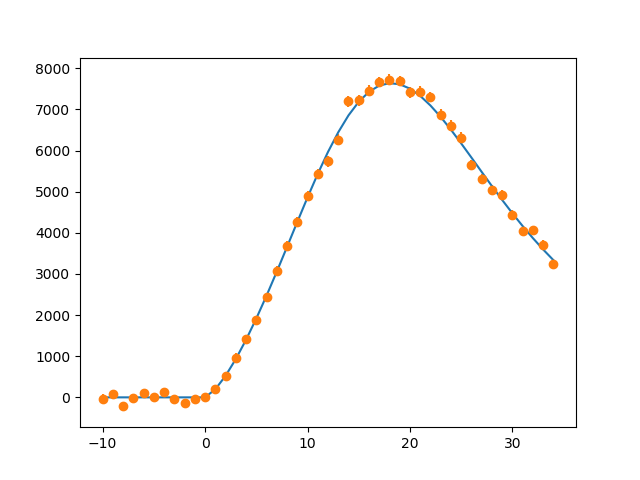

<ErrorbarContainer object of 3 artists>

In [33]:
sn1 = SimSnIa()
sn1.calc_a_prime()
sn1.calc_ft(np.arange(-10,35))
sn1.calc_noisy_lc(sigma_sys=100)

plt.plot(np.arange(-10,35), sn1.model_flux_)
plt.errorbar(np.arange(-10,35), sn1.cnts_, sn1.cnts_unc_, fmt='o')

<IPython.core.display.Javascript object>


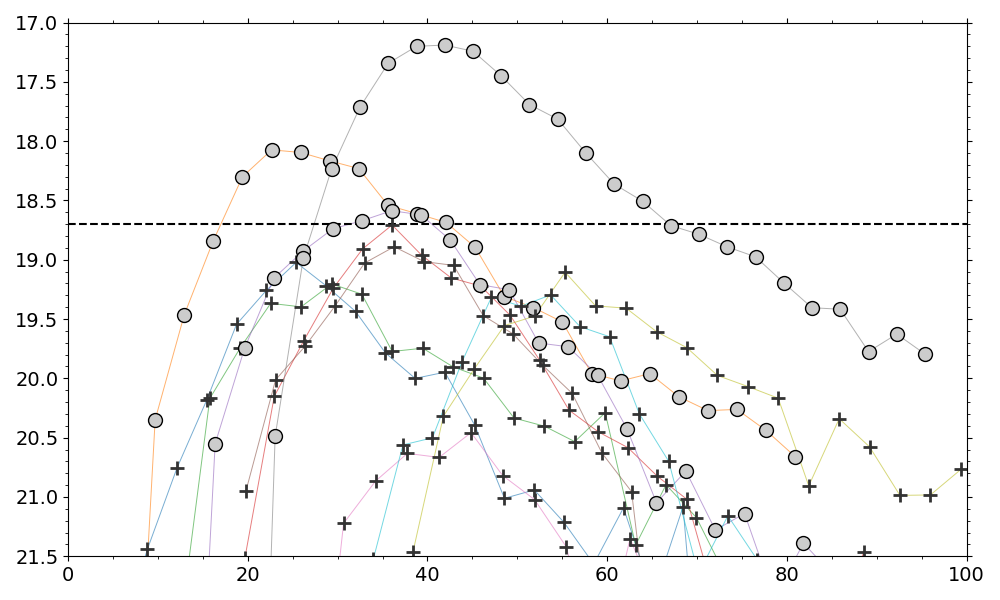

19.0228961392684
18.073529498238475
19.203951020400595
18.707302133213854
18.586685269022183
18.890464844957492
20.45735681630653
17.1900276123825
19.104823656352064
19.29701342649765


/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log10


In [35]:
np.random.seed(42)

fig, ax = plt.subplots(figsize=(10,6))

for i in range(10):
    sn = SimSnIa()
    sn.draw_dist_in_volume(d_max=600)
    dist = 0
    if i == 4:
        dist = 380
        sn.dist_ = dist
    elif i == 7:
        dist = 200
        sn.dist_ = dist
    elif i == 9:
        dist = 400
        sn.dist_ = dist
    elif i == 1:
        dist = 329
        sn.dist_ = dist
    elif i == 6:
        dist = 750
        sn.dist_ = dist
    
    if dist != 0:
        sn.z_ = 72*sn.dist_/2.9979e5
        sn.mu_ = 5*np.log10(sn.dist_)+25
            
    sn.draw_alpha_r()
    sn.draw_rise_time()
    sn.draw_smoothing_parameter()
    sn.draw_mb_deltam15()
    sn.calc_alpha_d()
    sn.calc_a_prime()
    
    if i == 0:
        t_start = np.random.randint(3) 
    else:
        t_start += np.random.randint(10)
    t_obs = np.arange(0, 75, 3, dtype=float) + np.random.uniform(-0.25/24,0.25/24,size=25)

    sn.calc_ft(t_obs)
    sn.calc_noisy_lc(sigma_sys=8)
    
    mag = 25 - 2.5*np.log10(sn.cnts_)
    mag_unc = 1.0857*sn.cnts_unc_/sn.cnts_

    print(np.nanmin(mag))
    if np.nanmin(mag) < 18.7:
        ax.plot((t_obs+t_start)*(1+sn.z_), mag, 'o',
                 c='0.8', mec='k', mew=1, ms=10)
        ax.plot((t_obs+t_start)*(1+sn.z_), mag, '-',
                 lw=0.7, alpha=0.6, zorder=-10)

    else:
        ax.plot((t_obs+t_start)*(1+sn.z_), mag, '+',
                 c='0.2', mew=2, ms=10)
        ax.plot((t_obs+t_start)*(1+sn.z_), mag, '-',
                 lw=0.7, alpha=0.6, zorder=-10)

ax.hlines(18.7, 0, 100, linestyles='--')
ax.set_ylim(21.5, 17)
ax.set_xlim(0,100)
ax.minorticks_on()
ax.tick_params(which='both',top=True, right=True, labelsize=14)
fig.tight_layout()
# fig.savefig("/Users/adamamiller/Desktop/BTS.pdf")